In [3]:
# initial data is in folder "/home/gablinux/futbol_db/events/"
# script to process the data and extract relevant info

%run "processing_event_files.py"

# After processing the event files, the output is in ...
# "/home/gablinux/futbol_db/shots_data/shots_db.json"

KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_json('/home/gablinux/futbol_db/shots_data/shots_db.json')

df.head()


In [ ]:
#del df
# generate features and store them in the feature store
# takes as input "/home/gablinux/futbol_db/shots_data/shots_db.json"

%run "preprocessing.py"

# output can be found in "/home/gablinux/futbol_db/shots_data/shots_db_features.json"

In [ ]:
# data visualization:
# import data
import pandas as pd

df = pd.read_json('/home/gablinux/futbol_db/shots_data/shots_db_features.json')
#df.head()


In [ ]:
goals = df[df.goal==1]
angles = goals["angles"].to_list()
dists = goals["distances"].to_list()
roles = goals["roles"].to_list()
positions = goals["positions"].to_list()
predxg = goals["predxg"].to_list()
gameid = goals["gameid"].to_list()

In [ ]:
from visualize_shots import visualize_shot

i = 0
# with i = 0 the goal we see is di maria 1-0, psg vs rennes, 2015/16
# https://youtu.be/94ysgAtztmY?si=XT4P0WPwGnUg1vAo
# the goal has a low xG, but it shouldnt because there is a teammate
# near the goalie, indicating that the ball came from him and he passed
# it from near the end line (cutback), making 
# much more dangerous if a teammate can impact it (which is the case
# because is a shot)


visualize_shot(goals, i)


In [3]:
from calculate_features import *
from dataset import ShotDataset, ShotLoader
from torch.utils.data import DataLoader
from model import xG_GCN
import datetime, os
from early_stop import EarlyStopping, EarlyStopper


model = xG_GCN()

lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 400
# Load the dataset
shot_dataset = ShotDataset()
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = \
    torch.utils.data.random_split(shot_dataset, [0.8, 0.1, 0.1],
                                  generator=generator)

batchsize = 64
train_dataloader = ShotLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_dataloader = ShotLoader(val_dataset, batch_size=batchsize, shuffle=True)

date_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
model_path = f'/home/gablinux/futbol_db/shots_data/model_{date_time}'
if not os.path.exists(model_path):
    os.makedirs(model_path)
#early_stopping = EarlyStopping(patience=15, verbose=True, path=model_path)
early_stopper = EarlyStopper(patience=20, wait=10, path=model_path)


In [4]:
train_losses = []
val_losses= []
stop_flg = 0
for e in range(epochs):
    # Training epoch
    model.train()
    train_sum, train_weights = 0., 0.
    for train_i, batch in enumerate(train_dataloader):
        X, L, target, mask, xg = vectorize_locations(batch)
        xg = torch.from_numpy(np.array(xg))

        optimizer.zero_grad()
        out = model(X, L, mask)
        loss_mask = torch.ones_like(target, device=X.device)

        loss = loss_fn(out, target.long())
        loss.backward()
        optimizer.step()
        train_sum += loss.item()
        train_weights += 1
    train_loss = train_sum / train_weights
    train_losses.append(train_loss)

        #lossxg = loss_fn(xg, target.long())

    #validation loss
    model.eval()
    val_sum, val_weights = 0., 0.
    for val_i, batch in enumerate(val_dataloader):
        X, L, target, mask, xg = vectorize_locations(batch)
        xg = torch.from_numpy(np.array(xg))

        with torch.no_grad():
            out = model(X, L, mask)
            val_loss = loss_fn(out, target.long())
            val_sum += val_loss.item()
            val_weights += 1
    val_loss = val_sum / val_weights
    val_losses.append(val_loss)

    # stoppage criterion: if validation loss has not improved for 5 epochs, stop training
    # get today's date to name the directory
    stop_flg = early_stopper.early_stop(val_loss, model, optimizer, e+1)
    
    if stop_flg:
        print(f"Early stopping at epoch {e+1}")
        break
        
        
    print(f"Epoch {e+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
print(early_stopper.best_checkpoint)
    

Epoch 1/400, Train Loss: 0.3602, Val Loss: 0.3665
Epoch 2/400, Train Loss: 0.3229, Val Loss: 0.3625
Epoch 3/400, Train Loss: 0.3200, Val Loss: 0.3494
Epoch 4/400, Train Loss: 0.3152, Val Loss: 0.3483
Epoch 5/400, Train Loss: 0.3109, Val Loss: 0.3317
Epoch 6/400, Train Loss: 0.3033, Val Loss: 0.3221
Epoch 7/400, Train Loss: 0.3010, Val Loss: 0.3141
Epoch 8/400, Train Loss: 0.2976, Val Loss: 0.3091
Epoch 9/400, Train Loss: 0.2961, Val Loss: 0.3087
Epoch 10/400, Train Loss: 0.2936, Val Loss: 0.3048
Epoch 11/400, Train Loss: 0.2916, Val Loss: 0.3064
Epoch 12/400, Train Loss: 0.2926, Val Loss: 0.2977
Epoch 13/400, Train Loss: 0.2889, Val Loss: 0.2962
Epoch 14/400, Train Loss: 0.2949, Val Loss: 0.3025
Epoch 15/400, Train Loss: 0.2918, Val Loss: 0.2942
Epoch 16/400, Train Loss: 0.2863, Val Loss: 0.2948
Epoch 17/400, Train Loss: 0.2864, Val Loss: 0.2963
Epoch 18/400, Train Loss: 0.2856, Val Loss: 0.2958
Epoch 19/400, Train Loss: 0.2839, Val Loss: 0.2875
Epoch 20/400, Train Loss: 0.2820, Val Lo

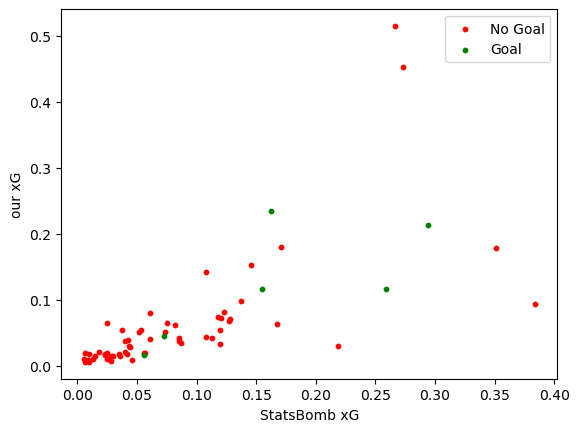

In [5]:
model.eval()
val_sum, val_weights = 0., 0.
for val_i, batch in enumerate(val_dataloader):
    X, L, target, mask, xg = vectorize_locations(batch)
    xg = torch.from_numpy(np.array(xg))

    with torch.no_grad():
        out = model(X, L, mask)
        val_loss = loss_fn(out, target.long())
        val_sum += val_loss.item()
        val_weights += 1
val_loss = val_sum / val_weights
val_losses.append(val_loss)

out_prob = torch.nn.functional.softmax(out, dim=-1)
goal_prob = out_prob[:,1].cpu().detach().numpy()

xg1 = xg.cpu().detach().numpy()
goal = target.cpu().detach().numpy()

xg_G = xg1[goal==1]
xg_N = xg1[goal==0]
prob_G = goal_prob[goal==1]
prob_N = goal_prob[goal==0]
#color = ['green' if g > 0.5 else 'red' for g in goal_prob]
#sizes = [25 if g > 0.5 else 5 for g in goal_prob]

import matplotlib.pyplot as plt
plt.scatter(xg_N, prob_N, color='red', s=10, label='No Goal')
plt.scatter(xg_G, prob_G, color='green', s=10, label='Goal')
plt.xlabel("StatsBomb xG")
plt.ylabel("our xG")
plt.legend()
plt.show()

In [6]:
torch.save(model.state_dict(), "model.pt")

In [7]:
## testing


test_dataloader = ShotLoader(test_dataset, batch_size=batchsize, shuffle=False)

#best_model_path = "model.pt"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#checkpoint = torch.load(best_model_path, map_location=device)


#model2 = xG_GCN()
#print(model.W_N.bias[0])

#model2.load_state_dict(checkpoint["model_state_dict"])
#print(model.W_N.bias[0])

#model2.eval()

test_sum, test_weights = 0., 0.

outs = []
targets = []
xgs = []
for test_i, batch in enumerate(test_dataloader):
    X, L, target, mask, xg = vectorize_locations(batch)
    xg = torch.from_numpy(np.array(xg))

    with torch.no_grad():
        out = model(X, L, mask)
        test_loss = loss_fn(out, target.long())
        test_sum += test_loss.item()
        test_weights += 1

    if test_i == 0:
        outs = torch.clone(out)
        targets = torch.clone(target)
        xgs = torch.clone(xg)
    else:
        outs = torch.cat((outs, out), dim=0)
        targets = torch.cat((targets, target), dim=0)
        xgs = torch.cat((xgs, xg), dim=0)

test_loss = test_sum / test_weights
print(X[0][0])
print(test_loss)

tensor([100.8000,  44.7000])
0.27866451293230055


In [6]:
xgsnp = torch.from_numpy(np.array(xgs)).unsqueeze(-1)
out_prob = torch.nn.functional.softmax(outs, dim=1)
print(out_prob[0,:])

tensor([0.7063, 0.2937])


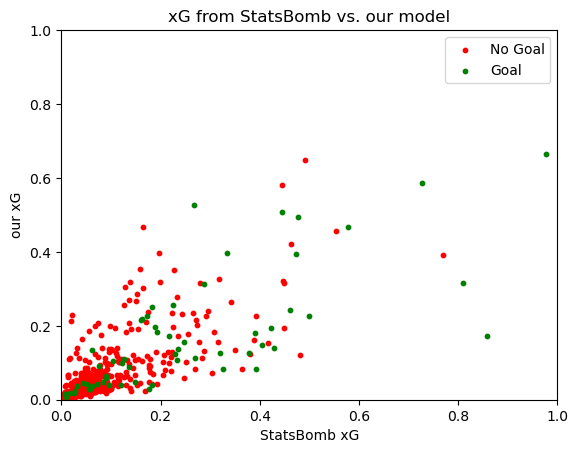

In [39]:
#out_prob = torch.nn.functional.softmax(outs, dim=-1)
#goal_prob = out_prob[:,1].cpu().detach().numpy()

#xg1 = xgs.cpu().detach().numpy()
#goal = targets.cpu().detach().numpy()

#xg_G = xg1[goal==1]
#xg_N = xg1[goal==0]
#prob_G = goal_prob[goal==1]
#prob_N = goal_prob[goal==0]
#color = ['green' if g > 0.5 else 'red' for g in goal_prob]
#sizes = [25 if g > 0.5 else 5 for g in goal_prob]

import matplotlib.pyplot as plt
plt.scatter(xg_N, prob_N, color='red', s=10, label='No Goal')
plt.scatter(xg_G, prob_G, color='green', s=10, label='Goal')
plt.xlabel("StatsBomb xG")
plt.ylabel("our xG")
plt.title("xG from StatsBomb vs. our model")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [9]:
print(torch.cat((outs, targets.unsqueeze(-1), xgs.unsqueeze(-1)), dim=-1))

tensor([[ 1.5872, -2.0257,  0.0000,  0.0344],
        [ 1.2260, -1.9247,  1.0000,  0.0962],
        [ 1.0000, -1.5993,  0.0000,  0.0593],
        ...,
        [ 0.0724, -0.5397,  0.0000,  0.2265],
        [ 1.2803, -1.8972,  0.0000,  0.0790],
        [ 1.4537, -2.1810,  0.0000,  0.0500]], dtype=torch.float64)


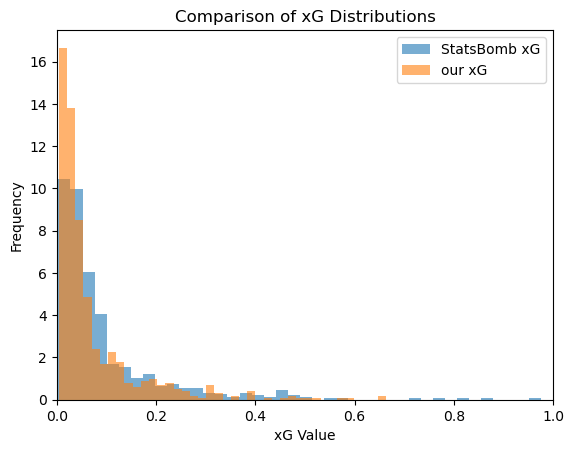

In [21]:
fig  = plt.figure()
plt.hist(xg1, bins=40, alpha=0.6, label='StatsBomb xG', density=True, stacked= True)
plt.hist(goal_prob, bins=40, alpha=0.6, label='our xG', density=True, stacked= True)
plt.xlabel('xG Value')
plt.ylabel('Frequency')
plt.title('Comparison of xG Distributions')
plt.xlim(0., 1.)
plt.legend()
#remove y axis

plt.show()

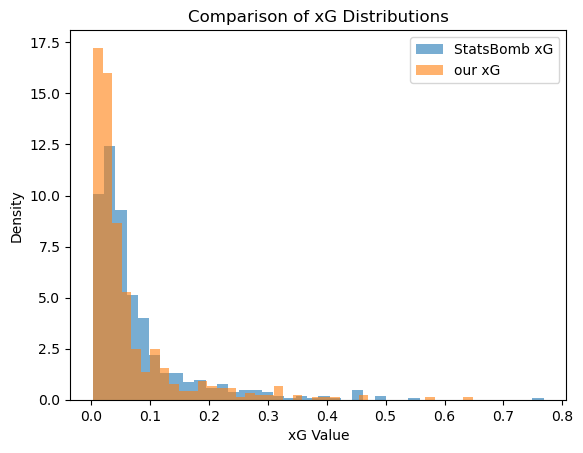

In [15]:
fig  = plt.figure()
plt.hist(xg_N, bins=40, density=True, alpha=0.6, label='StatsBomb xG')
plt.hist(prob_N, bins=40, density=True, alpha=0.6, label='our xG')
plt.xlabel('xG Value')
plt.ylabel('Density')
plt.title('Comparison of xG Distributions for non-Goals')
plt.legend()
plt.show()

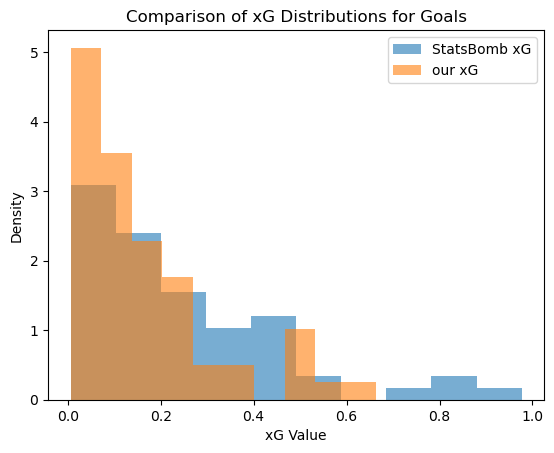

In [16]:
fig  = plt.figure()
plt.hist(xg_G, bins=10, density=True, alpha=0.6, label='StatsBomb xG')
plt.hist(prob_G, bins=10, density=True, alpha=0.6, label='our xG')
plt.xlabel('xG Value')
plt.ylabel('Density')
plt.title('Comparison of xG Distributions for Goals')
plt.legend()
plt.show()

In [ ]:
import mlflow
from mlflow.models import infer_signature

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params([])

    # Log the loss metric
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("train_loss", train_sum/train_weights)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "xG prediction Model")

    # Infer the model signature
    signature = infer_signature(X.numpy(), out.numpy())

    # Log the model
    mlflow.pytorch.log_model(model, "model", signature=signature)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batchsize)
    mlflow.log_param("learning_rate", lr)

In [ ]:
xg = torch.from_numpy(np.array(xg))
out_prob = torch.nn.functional.softmax(out, dim=1)
print(out_prob[0,:])

In [ ]:
print(torch.cat((out, target.unsqueeze(-1), xg.unsqueeze(-1)), dim=-1))

In [ ]:
out_prob = torch.nn.functional.softmax(out, dim=1)
goal_prob = out_prob[:,1].cpu().detach().numpy()
xg1 = xg.cpu().detach().numpy()
goal = target.cpu().detach().numpy()

xg_G = xg1[goal==1]
xg_N = xg1[goal==0]
prob_G = goal_prob[goal==1]
prob_N = goal_prob[goal==0]
#color = ['green' if g > 0.5 else 'red' for g in goal_prob]
#sizes = [25 if g > 0.5 else 5 for g in goal_prob]

import matplotlib.pyplot as plt
plt.scatter(xg_N, prob_N, color='red', s=10, label='No Goal')
plt.scatter(xg_G, prob_G, color='green', s=10, label='Goal')
plt.xlabel("StatsBomb xG")
plt.ylabel("our xG")
plt.legend()
plt.show()


In [40]:
from scipy.stats import spearmanr, pearsonr

a = spearmanr(xg1, goal_prob)
b = pearsonr(xg1, goal_prob)
print(f"Spearman correlation: {a[0]:.3f}")
print(f"Pearson correlation: {b[0]:.3f}")


Spearman correlation: 0.818
Pearson correlation: 0.768


In [41]:
a = spearmanr(xg_G, prob_G)
b = pearsonr(xg_G, prob_G)
print(f"Spearman correlation: {a[0]:.3f}")
print(f"Pearson correlation: {b[0]:.3f}")

Spearman correlation: 0.809
Pearson correlation: 0.733


In [42]:
a = spearmanr(xg_N, prob_N)
b = pearsonr(xg_N, prob_N)
print(f"Spearman correlation: {a[0]:.3f}")
print(f"Pearson correlation: {b[0]:.3f}")

Spearman correlation: 0.793
Pearson correlation: 0.743


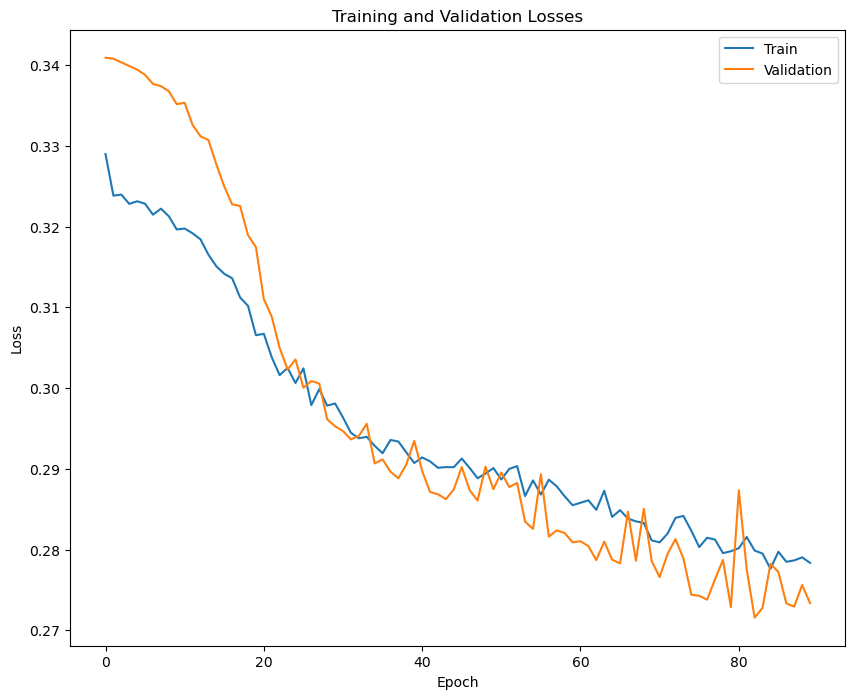

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(train_losses[1:])
plt.plot(val_losses[1:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend(['Train', 'Validation'])
plt.show()

In [43]:
# brier score:
import numpy as np
def brier_score(y_true, y_pred):
    """
    Calculates the Brier score for a set of true and predicted values.

    Args:
        y_true (numpy.ndarray): Array of true binary values (0 or 1).
        y_pred (numpy.ndarray): Array of predicted probabilities.
        Returns:
        float: Brier score, a value between 0 and 1, where 0 is a perfect score.
    """
    return np.mean((y_true - y_pred) ** 2)

print(brier_score(goal, xg1))
print(brier_score(goal, goal_prob))

0.07268184686899407
0.07968884372089975


In [24]:
#model2 = xG_GCN()

#model2.load_state_dict(torch.load("model.pt"))
model2.eval()

test_sum, test_weights = 0., 0.

outs = []
targets = 0
xgs = 0
for test_i, batch in enumerate(test_dataloader):
    X, L, target, mask, xg = vectorize_locations(batch)
    xg = torch.from_numpy(np.array(xg))

    with torch.no_grad():
        out = model2(X, L, mask)
        test_loss = loss_fn(out, target.long())
        test_sum += test_loss.item()
        test_weights += 1

    if test_i == 0:
        outs = torch.clone(out)
        targets = torch.clone(target)
        xgs = torch.clone(xg)
    else:
        outs = torch.cat((outs, out), dim=0)
        targets = torch.cat((targets, target), dim=0)
        xgs = torch.cat((xgs, xg), dim=0)

test_loss = test_sum / test_weights
print(test_loss)


0.3153106361627579


In [18]:
print(model.W_N.bias[0])
print(model2.W_N.bias[0])

tensor(-0.0631, grad_fn=<SelectBackward0>)
tensor(-0.0631, grad_fn=<SelectBackward0>)


In [22]:
## save numpy variables
# Save numpy array to file
np.save('goal.npy', goal)
np.save('goal_prob.npy', goal_prob)
np.save('xg1.npy', xg1)


In [34]:
import pandas as pd
import numpy as np

goal = np.load('goal.npy')
goal_prob = np.load('goal_prob.npy')
xg1 = np.load('xg1.npy')

df = pd.DataFrame({
    'StatsBomb xG': xg1,
    'our xG': goal_prob
})

xg_G = xg1[goal==1]
xg_N = xg1[goal==0]
prob_G = goal_prob[goal==1]
prob_N = goal_prob[goal==0]

dfG = pd.DataFrame({
    'StatsBomb xG': xg_G,
    'our xG': prob_G
})

dfN = pd.DataFrame({
    'StatsBomb xG': xg_N,
    'our xG': prob_N
})




/home/gablinux/miniconda3/envs/futbol/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


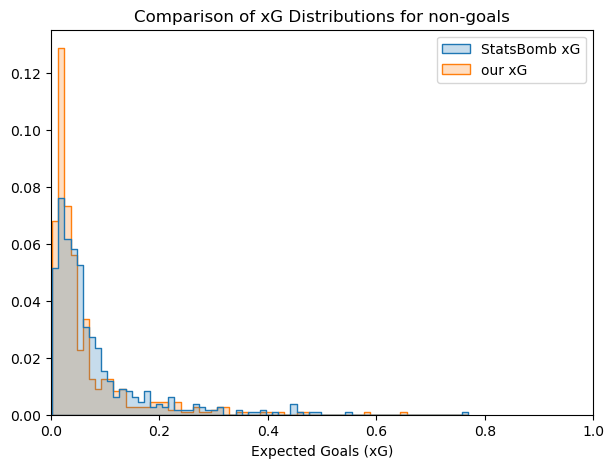

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
#sns.histplot(data = dfG, element="step", stat="probability", label="StatsBomb xG")
#sns.histplot(data = prob_N, element="step", stat="probability", label="our xG")
sns.histplot(data = dfN, element="step", stat="probability")
plt.xlabel("Expected Goals (xG)")
plt.ylabel("")
#plt.legend()
plt.xlim(0,1)
plt.title("Comparison of xG Distributions for non-goals")
plt.show()


/home/gablinux/miniconda3/envs/futbol/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


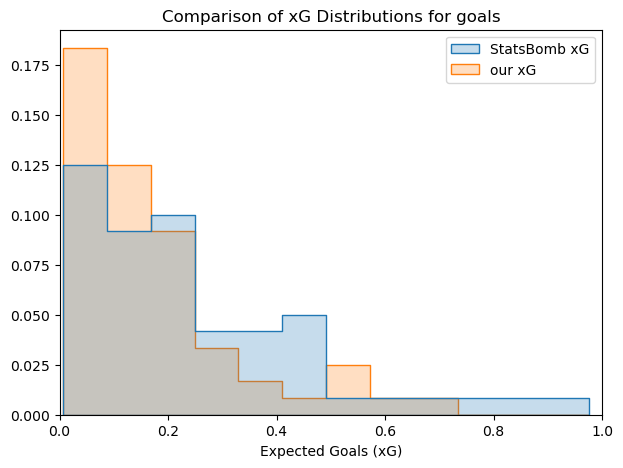

In [36]:
plt.figure(figsize=(7, 5))
#sns.histplot(data = xg_G, element="step", stat="probability", label="StatsBomb xG", bins=10)
#sns.histplot(data = prob_G, element="step", stat="probability", label="our xG", bins=10)
sns.histplot(data = dfG, element="step", stat="probability")
plt.xlabel("Expected Goals (xG)")
plt.ylabel("")
#plt.legend()
plt.xlim(0,1)
plt.title("Comparison of xG Distributions for goals")
plt.show()

/home/gablinux/miniconda3/envs/futbol/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


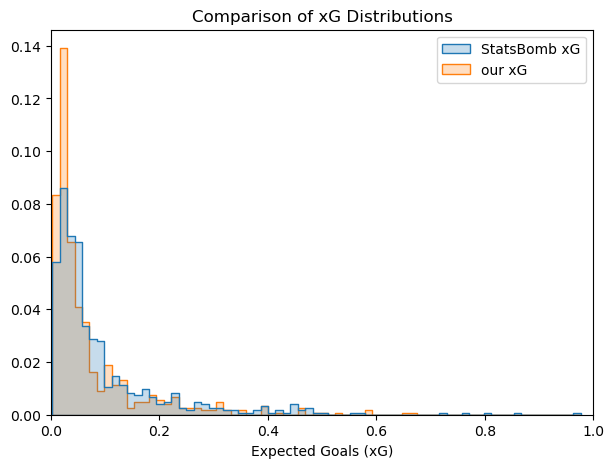

In [37]:
plt.figure(figsize=(7, 5))
#sns.histplot(data = xg1, element="step", stat="probability", label="StatsBomb xG")
#sns.histplot(data = goal_prob, element="step", stat="probability", label="our xG")
sns.histplot(data = df, element="step", stat="probability")
plt.xlabel("Expected Goals (xG)")
plt.ylabel("")
#plt.legend()
plt.xlim(0,1)
plt.title("Comparison of xG Distributions")
plt.show()

In [44]:
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(goal, goal_prob)
metrics.auc(fpr, tpr)

0.77307924984876

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(goal, xg1)
metrics.auc(fpr, tpr)

0.8032970356926801

In [46]:
len(goal)

611